In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.optimize as sco
import seaborn as sns
import statsmodels.formula.api as smf
import yfinance as yf

## Introduction
This report compares a static Equal Weight Risk Contribution (EWRC) portfolio against the Golden Butterfly (GB) portfolio.

1. Both portfolios use the same five assets: GLD, IEF, VTI, VIOV, VGLT
2. Sample period: January 2013 – October 2025
3. Objective: Evaluate whether risk parity improves diversification and risk-adjusted returns compared to an equally weighted portfolio
4. Main finding: EWRC successfully spreads risk evenly but underperforms Golden Butterfly in return and Sharpe ratio.
5. Cause: EWRC overweights bonds, but in this period both bond assets, IEF and VTI, had negative Sharpe ratios, while equities had better risk-adjusted returns.
6. Conclusion: Risk parity works effectively, but like any other portfolio construction method, it has limitations such as sensitivity to asset selection, reliance on historical risk estimates.

## Asset Sharpe Ratio
| Ticker | Sharpe Ratio |
|--------|---------------|
| GLD    |    0.32       |
| IEF    |   -0.023      |
| VGLT   |   -0.012      |
| VIOV   |    0.46       |
| VTI    |    0.75       |

1. Sharpe ratio shows return per unit of risk (William Sharpe,1964)
2. VTI (0.75) and VIOV (0.46) were the best risk-adjusted assets
3. IEF (-0.028) and VGLT (-0.016) had negative Sharpe ratios
4. GLD (0.31) offered moderate return efficiency

Key takeaway: Bonds did not reward risk in this period, which hurt EWRC because it allocated heavily to bonds with negative Sharpe ratio.

## Portfolio Weights
| Asset | EWRC Weights | GB Weights |
|--------|--------------|-------------|
| GLD    | 17.1%        | 20%         |
| IEF    | 36.2%        | 20%         |
| VTI    | 15.5%        | 20%         |
| VIOV   | 12.4%        | 20%         |
| VGLT   | 18.8%        | 20%         |

1. GB uses equal weights which spreads capital, not risk
2. EWRC overweights 55% in bonds and underweights 28% in equities to spread risk evenly
3. Because bonds had poor risk-adjusted return, EWRC increased exposure to weak assets in this period

## Risk Contributions
| Asset | EWRC_RC | GB_RC |
|--------|---------|-------|
| GLD    | ~20%    | 17.3% |
| IEF    | ~20%    | 5.9%  |
| VTI    | ~20%    | 28.8% |
| VIOV   | ~20%    | 37.1% |
| VGLT   | ~20%    | 10.9% |

1. EWRC weights assets so that each one contributes equally to the total portfolio risk
2. Golden Butterfly concentrates risk in equities, 66% of total risk from VTI and VIOV
3. EWRC removes equity dominance, while Golden Butterfly chases returns
4. Risk structure trade-off:
    a. EWRC = balanced and stable risk profile
    b. GB = return-seeking but risk concentrated in equities

## Performance Metrics
| Metric      | EWRC  | GB    |  
|-------------|-------|-------|
| CAGR        | 5.85% | 7.40% |
| Volatility  | 7.45% | 8.84% |
| Sharpe      | 0.54  | 0.63  |
| Sortino     | 0.71  | 0.81  |
| Max DD      |-20.9% |-21.1% |

1. Golden Butterfly outperformed EWRC in return and Sharpe ratio.
2. Volatility lower in EWRC due to risk balancing.
3. Drawdowns nearly identical: risk parity did not significantly improve downside protection.
4. EWRC underperformance not due to portfolio design, but poor Sharpe ratios in bonds it overweighted.

## Discussion and Evaluation
1. Main difference: Golden Butterfly spreads capital, EWRC spreads risk.
2. Golden Butterfly accepts equity risk to achieve higher long-term return while EWRC avoids risk concentration but gives up return.
3. Although bonds are safer assets, the negative Sharpe ratios over this sample hurt the performance metrics of EWRC.
4. Risk parity depends on asset Sharpe ratios, so if low-risk assets fail, performance suffers.
5. Leverage is often used to boost risk parity returns but is impractical for most DIY investors:
    a. Increases borrowing cost, and magnifying risk of losses
    b. Unavailable in many accounts
6. Overall, the choice depends on investor goals, risk tolerance, and whether they have the ability or interest to use leverage:
    a. Golden Butterfly: accepts higher concentrated risk for higher returns, simple to rebalance, and maintenance.
    b. EWRC: slightly complex, requires frequent rebalancing, but spreads risk evenly to limit the loss impact of any single asset.
    
## Limitations
1. Small asset universe (5 assets) limits diversification.
2. Static weights: With no rebalancing, weights drift over time.
3. No transaction costs included: EWRC would likely have higher trading cost in practice due to frequent rebalancing
4. Leverage has both benefits and drawbacks
5. EWRC overweighted bonds due to risk estimate, not return potential.
6. Weak sharpe ratio of some bond assets can hurt EWRC performance.
7. Sample period: results may change over different time horizon.

## Conclusion
1. EWRC successfully diversified risk: no asset dominated portfolio risk.
2. Golden Butterfly dominated performance: higher return and Sharpe across the period.
3. EWRC underperformed because it allocated to negative Sharpe bond assets.
4. Risk parity would be quite effective with better selection of assets.
5. Golden Butterfly might be more practical for leverage aversive investors
6. EWRC is better suited for investors who prefer to control risk contribution of each asset with the ability to leverage for higher expected returns

## Reference
1. Qian, Edward. “Risk Parity and Diversification.” Journal of Investing, vol. 20, no. 1, Spring 2011, pp. 119–127.
2. Sharpe, William F. “Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk.” The Journal of Finance, vol. 19, no. 3, 1964, pp. 425–42. JSTOR, https://doi.org/10.2307/2977928. Accessed 16 Oct. 2025.

In [2]:
tickers = [
    'GLD',
    'IEF',  
    'VTI',  
    'VIOV',
    'VGLT'
]
returns = (
    yf.download(
        tickers=tickers,
        start = '2013-01-01',
        auto_adjust=False,
        progress=False
    )
    ['Adj Close']
    .iloc[:-1]
    .pct_change()
    .dropna()
)
Rf = (
    pdr.DataReader(
    name='F-F_Research_Data_Factors_daily',
    data_source='famafrench',start='2013')[0]
    .div(100)[['RF']]
)

C:\Users\khans\AppData\Local\Temp\ipykernel_7844\181093777.py:21: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


In [3]:
def calc_rc(w, Sigma):
    return (w * (Sigma @ w)) / (w.T @ Sigma @ w)
    
def f(w, Sigma):
    N = Sigma.shape[0]
    error = calc_rc(w=w, Sigma=Sigma) - 1 / N
    return (error**2).sum()
    
def calc_ew(Sigma):
    N = Sigma.shape[0]
    return np.ones(N) / N

In [4]:
Sigma = 252 * returns[['GLD', 'IEF', 'VTI','VIOV','VGLT']].cov()
w_ew = calc_ew(Sigma)
eqw_rc = calc_rc(w = w_ew, Sigma=Sigma).to_frame('GoldenB_RC')

result_eqrc = sco.minimize(
    fun=f,
    x0=w_ew,
    args=(Sigma,),
    bounds=((0, 1) for _ in range(Sigma.shape[0])),
    constraints=(
        {'type': 'eq', 'fun': lambda w: w.sum() - 1}
    )
)
assert result_eqrc['success']

ewRisk = calc_rc(w=result_eqrc['x'], Sigma=Sigma).to_frame('EWRC')
df = pd.concat([ewRisk,eqw_rc['GoldenB_RC']], axis = 1)
df_rc = df.style.format('{:.1%}')

In [5]:
portfolios = pd.DataFrame(
    {
        'EWRC_PortW': result_eqrc['x'],
        'GoldenB_PortW': [0.20] * len(tickers)
    },
    index=tickers
).rename_axis(index='Ticker', columns='Portfolio')
portW = portfolios.style.format('{:.1%}')
portfolio_returns = (
    pd.concat([
        returns.dot(portfolios[['EWRC_PortW']]).rename(columns={'EWRC_PortW': 'EWRC'}),
        returns.dot(portfolios[['GoldenB_PortW']]).rename(columns={'GoldenB_PortW': 'GoldenB'})
    ], axis=1))

In [6]:
def Volatility(x,ppy=252):
    return x.std() * np.sqrt(ppy)
def Drawdown(x):
    price = x.add(1).cumprod()
    return (price / price.cummax()) - 1
def MaxDrawdown(x):
    price = x.add(1).cumprod()
    return (price / price.cummax()).min() - 1
def CAGR(x):
    T = x.count()
    return (x.add(1).prod()) ** (252/T) - 1
def Sortino(rp, ann_fac=np.sqrt(252)):
    rf = Rf['RF']
    excess = rp.sub(rf, axis=0)
    downside = excess[excess < 0]
    downside_std = downside.std()
    return ann_fac * excess.mean() / downside_std
def Sharpe(rp, ann_fac=np.sqrt(252)):
    rf = Rf['RF']
    excess = rp.sub(rf, axis=0).dropna()
    return ann_fac * excess.mean() / excess.std()

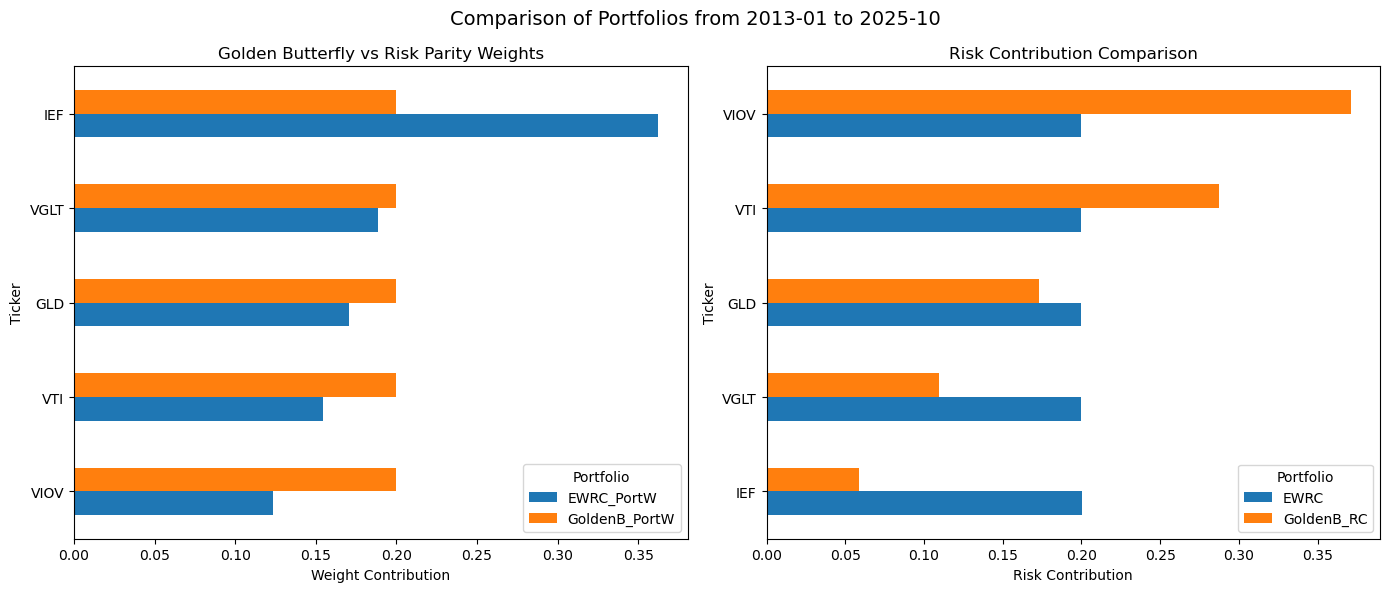

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
portfolios[['EWRC_PortW', 'GoldenB_PortW']].sort_values(by='EWRC_PortW').plot(kind='barh',ax=axes[0])
axes[0].set_xlabel('Weight Contribution')
axes[0].set_title('Golden Butterfly vs Risk Parity Weights')
axes[0].legend(title='Portfolio')
df[['EWRC', 'GoldenB_RC']].sort_values(by='GoldenB_RC').plot(kind='barh',ax=axes[1])

axes[1].set_xlabel('Risk Contribution')
axes[1].set_title('Risk Contribution Comparison')
axes[1].legend(title='Portfolio')
fig.suptitle(f'Comparison of Portfolios from {returns.index[0]:%Y-%m} to {returns.index[-1]:%Y-%m}', fontsize=14)
plt.tight_layout()
plt.show()

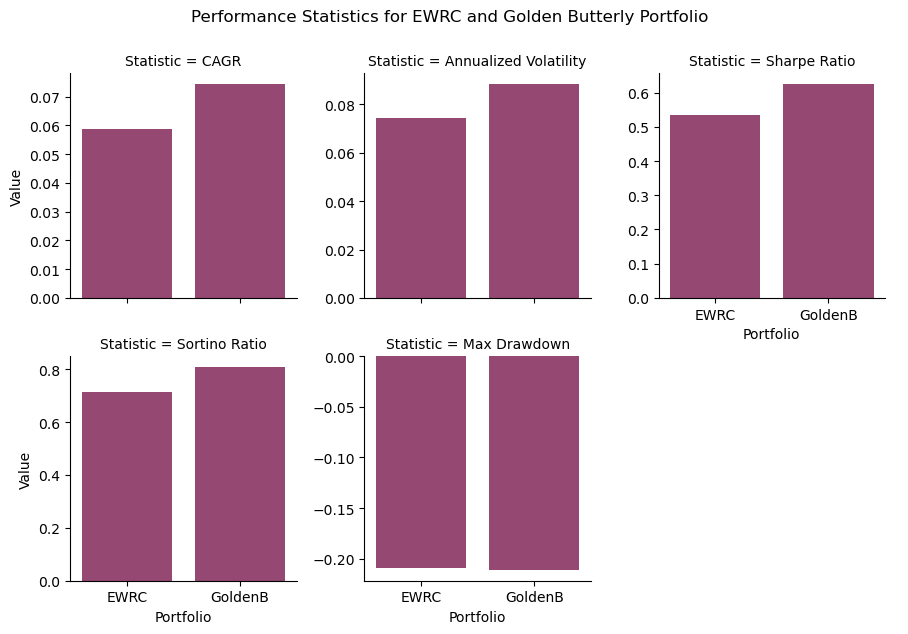

In [8]:
stats = (
    portfolio_returns
        .agg([CAGR,Volatility,Sharpe,Sortino,MaxDrawdown])
        .transpose()
        .rename_axis(columns='Statistic')
).rename(columns = {'CAGR':'CAGR','Volatility':'Annualized Volatility',
                    'Sharpe':'Sharpe Ratio',
                    'Sortino':'Sortino Ratio',
                    'MaxDrawdown':'Max Drawdown'}
        )
asset_sharpe = Sharpe(rp=returns).sort_values()
df = stats.stack().to_frame('Value').reset_index()
sns.catplot(
    data=df,
    x='Portfolio',
    y='Value',
    col='Statistic',
    col_wrap=3,
    height=3,
    kind='bar',
    sharey=False,
    color = '#A23B72'
)
plt.suptitle('Performance Statistics for EWRC and Golden Butterly Portfolio', y=1.05)
plt.show()

In [9]:
display(stats.style.format({
    'CAGR': '{:.2%}',
    'Annualized Volatility': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Sortino Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}',
}))

Statistic,CAGR,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Portfolio,,,,,
EWRC,5.88%,7.45%,0.54,0.71,-20.91%
GoldenB,7.44%,8.84%,0.63,0.81,-21.11%


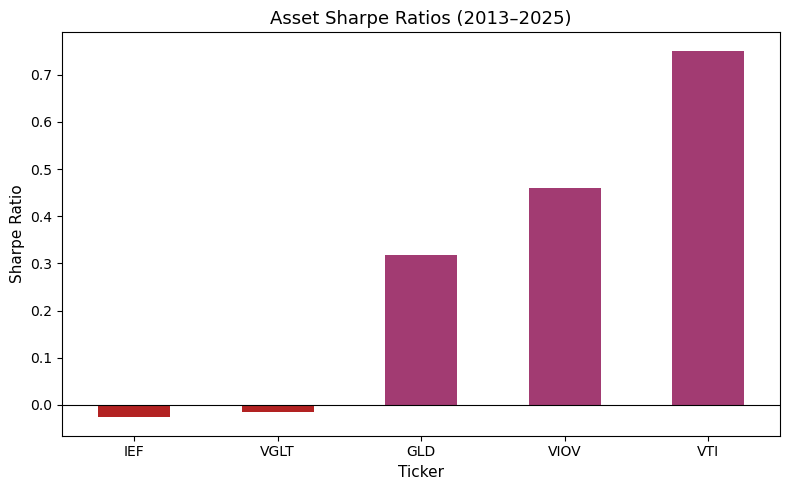

In [14]:
plt.figure(figsize=(8,5))
asset_sharpe.plot(kind='bar', color=['#B22222' if x < 0 else '#A23B72' for x in asset_sharpe])
plt.title('Asset Sharpe Ratios (2013–2025)', fontsize=13)
plt.xlabel('Ticker', fontsize=11)
plt.ylabel('Sharpe Ratio', fontsize=11)
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

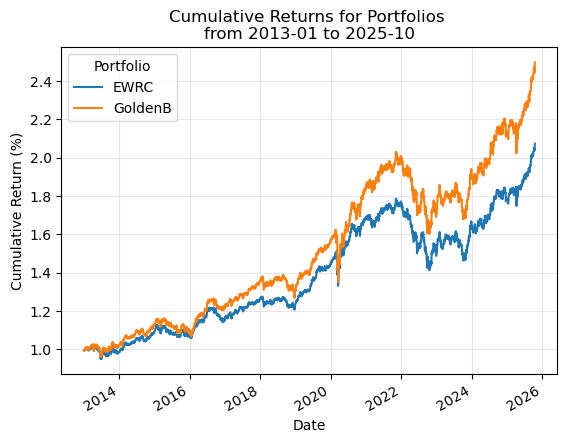

<Axes: title={'center': 'DrawDown for Portfolios from 2013 to 2025'}, xlabel='Date'>

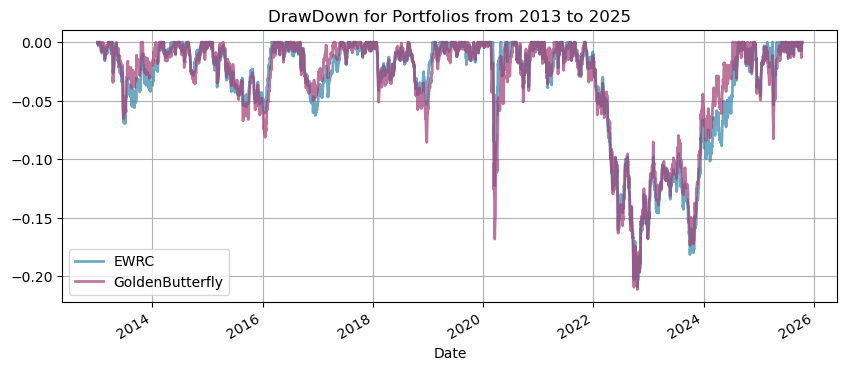

In [12]:
portfolio_returns.add(1).cumprod().plot()
plt.title(f'Cumulative Returns for Portfolios \nfrom {returns.index[0]:%Y-%m} to {returns.index[-1]:%Y-%m}')
plt.grid(True, alpha=0.3)
plt.ylabel('Cumulative Return (%)')
plt.show()

drawdowns = pd.DataFrame({
    'EWRC': Drawdown(portfolio_returns['EWRC']),
    'GoldenButterfly': Drawdown(portfolio_returns['GoldenB'])
})
fig, ax = plt.subplots(figsize=(10, 4))
drawdowns.plot(ax=ax, linewidth=2, color=['#2E86AB', '#A23B72'], alpha=0.7, title = 'DrawDown for Portfolios from 2013 to 2025', grid = 'on')